# **Basic Molecular Docking**

This <font color='orange'>**LABO**</font>**DOCK** notebook is designed for conducting basic molecular docking procedures using **Autodock Vina 1.2.5** and performing binding interaction analysis with **PLIP 2.3.0**.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RyanZR/labodock/blob/main/notebooks/basic_molecular_docking.ipynb)
[![version](https://img.shields.io/badge/version-2.0.0-blue)](https://github.com/RyanZR/labodock/tree/main/notebooks)
[![DOI](https://img.shields.io/badge/DOI-10.5281/zenodo.8246977-blue)](https://doi.org/10.5281/zenodo.8246977)

---
---
# **01 | Setting Up Environment**

Firstly, we install all the necessary libraries and packages.

The main packages that will be installed include:

+ AutoDock Vina 1.2.5 (https://vina.scripps.edu/)
+ Condacolab 0.1.7 (https://github.com/conda-incubator/condacolab)
+ Meeko 0.5.0 (https://github.com/forlilab/Meeko)
+ OpenBabel 3.1.1 (https://github.com/openbabel/openbabel)
+ PLIP 2.3.0 (https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index)
+ Py3Dmol 2.0.3 (https://pypi.org/project/py3Dmol/)
+ Rdkit 2022.9.5 (https://github.com/rdkit/rdkit)
+ Spyrmsd 0.6.0 (https://github.com/RMeli/spyrmsd)

All the above libraries and packages are currently supported by **Python 3.10**.

In [1]:
# @title **Install packages and dependencies**
# @markdown Thanks to **`mamba`**, the installation takes **less than 2 mins**. \
# @markdown It will **restart** the kernel (session).

import sys
import time
import contextlib

with open('/content/labodock_install.log', 'a') as inpt:
    with contextlib.redirect_stdout(inpt):

        # -- Start installation --
        start = time.time()
        !rm -r /content/sample_data
        !wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.5/vina_1.2.5_linux_x86_64 -O vina
        !chmod u+x vina

        !pip install py3Dmol==2.0.3
        !pip install rdkit-pypi==2022.9.5
        !pip install meeko==0.5.0
        !pip install condacolab==0.1.7
        !pip install pandas

        !apt-get -qq install -y plip
        !pip install spyrmsd
        !apt-get -qq install -y openbabel
        end = time.time()
        # -- End installation --

        print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

In [2]:
# @title **Import Python modules**
# @markdown This will import the necessary Python modules.

# Internal Modules
import os
import glob
import time
import shutil

# External modules
import py3Dmol
import plip

# Data-related
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Google Colab-related
from google.colab import drive, files
from tqdm.notebook import tqdm

# Docking-related
from rdkit import Chem, RDLogger
from rdkit.Chem import rdFMCS, AllChem, Draw
from spyrmsd import io, rmsd

# Binding interaction-related
from plip.exchange.report import BindingSiteReport
from plip.structure.preparation import PDBComplex

print(f'+ Import completed')

+ Import completed


In [3]:
# @title **Create folders**
# @markdown Enter a **< Job Name >** to create a working directory containing:
# @markdown + **`PROTEIN`** : Stores the target protein
# @markdown + **`LIGAND`** : Stores the ligand to be docked
# @markdown + **`NATIVE`** : Stores the native ligand of target protein
# @markdown + **`DOCK`** : Stores the docking pose and scoring data
# @markdown + **`INTERACTION`** : Stores the binding interaction data

Job_name = '6WV3'   # @param {type: 'string'}

invalid_chars = '^<>/\\{}[]~`$ '
assert Job_name, 'Do not leave this blank.'
assert not set(invalid_chars).intersection(Job_name), 'Disallowed characters.'

DIR = os.getcwd()
WRK_DIR = os.path.join(DIR, Job_name)
PRT_FLD = os.path.join(WRK_DIR, 'PROTEIN')
LIG_FLD = os.path.join(WRK_DIR, 'LIGAND')
NTV_FLD = os.path.join(WRK_DIR, 'NATIVE')
DCK_FLD = os.path.join(WRK_DIR, 'DOCKING')
INT_FLD = os.path.join(WRK_DIR, 'INTERACTION')

folders = [WRK_DIR, PRT_FLD, LIG_FLD, NTV_FLD, DCK_FLD, INT_FLD]

for folder in folders:
    if os.path.exists(folder):
        print(f'+ Folder existed: {folder}')
    else:
        os.mkdir(folder)
        print(f'+ Folder created: {folder}')

+ Folder created: /content/6WV3
+ Folder created: /content/6WV3/PROTEIN
+ Folder created: /content/6WV3/LIGAND
+ Folder created: /content/6WV3/NATIVE
+ Folder created: /content/6WV3/DOCKING
+ Folder created: /content/6WV3/INTERACTION


In [4]:
# @title **Set up utilities**
# @markdown This creates important custom functions and methods for later
# @markdown docking and binding interaction study.

%alias vina /content/vina

#############################################
# Suppress Warnings

RDLogger.DisableLog('rdApp.warning')

#############################################
# Grid Box Calculation Methods

class GridBox:

    ranges = tuple[list[float], list[float], list[float]]
    coords = tuple[float, float, float]
    center_bxsize = tuple[tuple[float, float, float], tuple[float, float, float]]

    def __init__(self, inpt_file: str) -> None:
        self.inpt = open(inpt_file, 'r')
        self.data = self.inpt.read()
        self.cmol = Chem.MolFromPDBBlock(self.data)
        self.conf = self.cmol.GetConformer()
        self.ntom = self.cmol.GetNumAtoms()
        self.inpt.close()

    def update_gridbox(self, mol_block: str) -> None:
        self.cmol = Chem.MolFromPDBBlock(mol_block)
        self.conf = self.cmol.GetConformer()
        self.ntom = self.cmol.GetNumAtoms()

    def compute_coords(self) -> ranges:
        x_coord = [self.conf.GetAtomPosition(c).x for c in range(self.ntom)]
        y_coord = [self.conf.GetAtomPosition(c).y for c in range(self.ntom)]
        z_coord = [self.conf.GetAtomPosition(c).z for c in range(self.ntom)]
        return x_coord, y_coord, z_coord

    def compute_ranges(self) -> ranges:
        x, y, z = self.compute_coords()
        x_range = [min(x), max(x)]
        y_range = [min(y), max(y)]
        z_range = [min(z), max(z)]
        return x_range, y_range, z_range

    def compute_center(self, use_range: bool = True) -> coords:
        x, y, z = self.compute_ranges() if use_range else self.compute_coords()
        x_center = round(np.mean(x), 3)
        y_center = round(np.mean(y), 3)
        z_center = round(np.mean(z), 3)
        return x_center, y_center, z_center

    def generate_res_molblock(self, residues_list: list[str]) -> str:
        res_lines = [line for line in self.data.split('\n')
                     if line[22:26].lstrip() in residues_list
                     and 'END' not in line]
        res_block = '\n'.join(res_lines)
        return res_block

    def labox(self, scale: float = 2.0) -> coords:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (round(abs(xr[0] - xr[1]) * scale, 3),
                  round(abs(yr[0] - yr[1]) * scale, 3),
                  round(abs(zr[0] - zr[1]) * scale, 3))
        return center, bxsize

    def eboxsize(self, gy_box_ratio: float = 0.23, modified: bool = False) -> center_bxsize:
        xc, yc, zc = self.compute_coords()
        center = self.compute_center(modified)
        distsq = [(x-center[0])**2 + (y-center[1])**2 + (z-center[2])**2
                  for x, y, z in zip(xc, yc, zc)]
        bxsize = (round(np.sqrt(sum(distsq) / len(xc)) / gy_box_ratio, 3),) * 3
        return center, bxsize

    def autodock_grid(self) -> center_bxsize:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (22.5, 22.5, 22.5)
        return center, bxsize

    def defined_by_res(self, residue_number: str, scale: float = 1.25) -> center_bxsize:
        res_list = residue_number.replace(',', ' ').split()
        res_block = self.generate_res_molblock(res_list)
        self.update_gridbox(res_block)
        return self.labox(scale=scale)

#############################################
# RMSD Calculation Methods

class ComputeRMSD:

    def __init__(self) -> None:
        self.MCS_mol = None
        self.MCS_png = None

    def load_molecule(self, inpt_file: str, remove_Hs: bool = True) -> tuple:
        molecule = io.loadmol(inpt_file)
        molecule.strip() if remove_Hs else None
        name = os.path.basename(inpt_file).split('.')[0]
        coor = molecule.coordinates
        anum = molecule.atomicnums
        mtrx = molecule.adjacency_matrix
        cmol = Chem.MolFromPDBFile(inpt_file)
        return name, coor, anum, mtrx, cmol

    def mol_to_png(self, mol: object) -> object:
        legend = 'Maximum Common Substructure'
        png = Draw.MolToImage(mol, legend=legend)
        return png

    def find_MCS(self, ref: tuple, lig: tuple) -> object:
        if self.MCS_mol is None:
            MCS_obj = rdFMCS.FindMCS([ref[4], lig[4]])
            MCS_mol = Chem.MolFromSmarts(MCS_obj.smartsString)
            MCS_png = self.mol_to_png(MCS_mol)
            self.MCS_mol = MCS_mol
            self.MCS_png = MCS_png
        return self.MCS_mol

    def hung_RMSD(self, ref: tuple, lig: tuple) -> float:
        try:
            hRMSD = round(rmsd.hrmsd(ref[1], lig[1], ref[2], lig[2]), 3)
        except:
            hRMSD = 'ERROR'
        return hRMSD

    def symm_RMSD(self, ref: tuple, lig: tuple, minimise: bool = False) -> float:
        try:
            sRMSD = round(rmsd.symmrmsd(ref[1], lig[1], ref[2], lig[2], ref[3], lig[3], minimize=minimise), 3)
        except:
            sRMSD = 'ERROR'
        return sRMSD

    def labo_RMSD(self, ref: tuple, lig: tuple) -> float:
        mol_substr = self.find_MCS(ref, lig)
        ref_substr = ref[4].GetSubstructMatch(mol_substr)
        lig_substr = lig[4].GetSubstructMatch(mol_substr)

        distsq = []
        for ref_atom, lig_atom in zip(ref_substr, lig_substr):
            ref_pos = ref[4].GetConformer().GetAtomPosition(ref_atom)
            lig_pos = lig[4].GetConformer().GetAtomPosition(lig_atom)
            ref_coord = np.array((ref_pos.x, ref_pos.y, ref_pos.z))
            lig_coord = np.array((lig_pos.x, lig_pos.y, lig_pos.z))
            coo_dist = np.linalg.norm(ref_coord - lig_coord)
            distsq.append(coo_dist ** 2)

        try:
            lRMSD = round(np.sqrt(sum(distsq)/len(distsq)), 3)
        except:
            lRMSD = 'ERROR'
        return lRMSD

    def rmsd_report(self,
                    ref: tuple,
                    lig: tuple,
                    lRMSD: bool = True,
                    hRMSD: bool = True,
                    sRMSD: bool = True
                    ) -> dict[str: list[float]]:
        report = {}
        report['NAME'] = [lig[0]]
        report['LABO_RMSD'] = [self.labo_RMSD(ref, lig)] if lRMSD else None
        report['HUNG_RMSD'] = [self.hung_RMSD(ref, lig)] if hRMSD else None
        report['SYMM_RMSD'] = [self.symm_RMSD(ref, lig)] if sRMSD else None
        report = {k: v for k, v in report.items() if v is not None}
        return report

#############################################
# AA Consntant and Bond Colour Dictionary

# Kyte and Doolittle Hydropathy Scale (1982)
AA_HB = {'ALA':  1.8, 'ARG': -4.5, 'ASN': -3.5, 'ASP': -3.5, 'CYS':  2.5,
         'GLN': -3.5, 'GLU': -3.5, 'GLY': -0.4, 'HIS': -3.2, 'ILE':  4.5,
         'LEU':  3.8, 'LYS': -3.9, 'MET':  1.9, 'PHE':  2.8, 'PRO': -1.6,
         'SER': -0.8, 'THR': -0.7, 'TRP': -0.9, 'TYR': -1.3, 'VAL':  4.2}

# University of Calgary PI Scale
AA_PI = {'ALA':  6.0, 'ARG': 10.76, 'ASN': 5.41, 'ASP': 2.77, 'CYS': 5.07,
         'GLN': 5.65, 'GLU':  3.22, 'GLY': 5.97, 'HIS': 7.59, 'ILE': 6.02,
         'LEU': 5.98, 'LYS':  9.74, 'MET': 5.74, 'PHE': 5.48, 'PRO':  6.3,
         'SEC': 5.68, 'SER':  5.68, 'THR':  5.6, 'TRP': 5.89, 'TYR': 5.66,
         'VAL': 5.96}

BOND_COL = {'HYDROPHOBIC': ['0x59e382', 'GREEN'],
            'HBOND': ['0x59bee3', 'LIGHT BLUE'],
            'WATERBRIDGE': ['0x4c4cff', 'BLUE'],
            'SALTBRIDGE': ['0xefd033', 'YELLOW'],
            'PISTACKING': ['0xb559e3', 'PURPLE'],
            'PICATION': ['0xe359d8', 'VIOLET'],
            'HALOGEN': ['0x59bee3', 'LIGHT BLUE'],
            'METAL':['0xe35959', 'ORANGE']}

#############################################
# AA-to-Colour Converter Function

def sequential_gradient(value: float,
                        min_value: float,
                        max_value: float,
                        targ_colour: str = '00ff00',
                        interpolation: float = 0.0
                        ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    rgb = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))
    r = int(255 - (255 - rgb[0]) * (1 - interpolation) * norm_val)
    g = int(255 - (255 - rgb[1]) * (1 - interpolation) * norm_val)
    b = int(255 - (255 - rgb[2]) * (1 - interpolation) * norm_val)

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def diverging_gradient(value: float,
                       min_value: float,
                       max_value: float,
                       base_colour: str = 'ff0000',
                       targ_colour: str = '0000ff',
                       interpolation: float = 0.3
                       ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)

    white = (255, 255, 255)
    rgb_A = tuple(int(base_colour[d:d+2], 16) for d in (0, 2, 4))
    rgb_B = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))

    if norm_val < 0.5 - interpolation / 2:
        factor = norm_val / (0.5 - interpolation / 2)
        r = int(rgb_A[0] + (white[0] - rgb_A[0]) * factor)
        g = int(rgb_A[1] + (white[1] - rgb_A[1]) * factor)
        b = int(rgb_A[2] + (white[2] - rgb_A[2]) * factor)
    elif norm_val > 0.5 + interpolation / 2:
        factor = (norm_val - 0.5 - interpolation / 2) / (0.5 - interpolation / 2)
        r = int(white[0] + (rgb_B[0] - white[0]) * factor)
        g = int(white[1] + (rgb_B[1] - white[1]) * factor)
        b = int(white[2] + (rgb_B[2] - white[2]) * factor)
    else:
        r, g, b = white

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def a2c_converter(aa_map: dict, grad_func: 'function') -> dict:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())
    aa_dict = {aa: grad_func(value, min_value, max_value)
               for aa, value in aa_map.items()}
    return aa_dict

#############################################
# Built-in Styling Function

def builtin_style(style: str, opacity: float = 1.0) -> dict:
    match style:
        case _ if any(kw in style for kw in ('Carbon', 'chain', 'ssJmol', 'ssPyMol')):
            style_dict = {'colorscheme': style}
        case 'hydrophobicity':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_HB, sequential_gradient)}}
        case 'isoelectric points':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_PI, diverging_gradient)}}
        case 'b factor':
            style_dict = {'colorscheme': {
                'prop': 'b', 'gradient': 'rwb', 'min': 90, 'max': 50}}
        case _:
            style_dict = {'color': style}

    style_dict.update({'opacity': opacity, 'singleBonds': False})
    return style_dict

#############################################
# Built-in Colour Scale Function

def colour_scale(aa_map: dict, grad_func: 'function') -> None:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())

    linear_values = np.linspace(min_value, max_value, 100)
    colours = [grad_func(value, min_value, max_value)
               for value in linear_values]

    fig, ax = plt.subplots(figsize=(4.85, 0.25))
    norm_value = plt.Normalize(min_value, max_value)
    colour_map = plt.cm.colors.ListedColormap(colours)
    scalar_map = plt.cm.ScalarMappable(norm_value, colour_map)
    scalar_map.set_array([])

    cscale = plt.colorbar(scalar_map, ax, orientation='horizontal')
    cscale.set_ticks([min_value, max_value])

def show_cscale(rept_info: dict, surf_info: dict) -> None:

    def cs_selector() -> str:
        if any(surf_info):
            style = [*surf_info.values()][0]
        elif any(rept_info):
            style = [*rept_info.values()][0]
        else:
            style = None
        return style

    def cs_display(style: str):
        if style == 'hydrophobicity':
            label_title(style, 'Less', 'More')
            colour_scale(AA_HB, sequential_gradient)
        elif style == 'isoelectric points':
            label_title(style, 'Acid', 'Base')
            colour_scale(AA_PI, diverging_gradient)
        else:
            pass

    def label_title(text: str, min: str, max: str) -> None:
        print(f'-' * 55)
        print(f'{min}{text.upper():^47}{max}')
        print(f'-' * 55)

    cs_display(cs_selector())

#############################################
# Other Functions

def extract_config(inpt_file: str) -> tuple:
    with open(inpt_file, 'r') as inpt:
        data = [line.split() for line in inpt.readlines()]
    center = (float(data[0][2]), float(data[1][2]), float(data[2][2]))
    bxsize = (float(data[4][2]), float(data[5][2]), float(data[6][2]))
    return center, bxsize

def interaction_dict(inpt_file: str, interactions: str = '', usage: str = 'view' or 'lbsp') -> dict:

    usg_map = {'lbsp': 0, 'view': 1}

    def filter_df(int_df: pd.DataFrame, interactions: list = []) -> pd.DataFrame:
        int_df = int_df[int_df['BOND'].isin(interactions)] if interactions else int_df
        return int_df

    def s2f_dict(item: dict) -> dict:
        return {key: tuple(float(val) for val in value[1:-1].split(','))
                for key, value in item.items()}

    def b2c_dict(item: dict) -> dict:
        return {key: BOND_COL[val][usg_map[usage]] for key, val in item.items()}

    intrxn = interactions.replace(',', ' ').split()
    inter_df = pd.read_csv(inpt_file)
    int_dict = filter_df(inter_df, intrxn).to_dict()
    int_dict['LIGCOO'] = s2f_dict(int_dict['LIGCOO'])
    int_dict['PROTCOO'] = s2f_dict(int_dict['PROTCOO'])
    int_dict['COLOR'] = b2c_dict(int_dict['BOND'])

    return int_dict

def find_midpoint(coords: list) -> tuple[float, float, float]:
    return tuple(round(coord, 3) for coord in np.mean(coords, axis=0))

#############################################
# LaboSpace Viewer

class LaboSpace:

    residue_style = {
        'stick':
         {'colorscheme': 'orangeCarbon', 'radius': 0.15}}
    residue_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 25, 'y': 25}}
    atom_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 10, 'y': 10}}

    def __init__(self, vw: int = 500, vh: int = 500) -> None:
        self.mview = py3Dmol.view(width=vw, height=vh)
        self.count = -1
        self.residues = []

    def read_moldata(self, inpt_file: str) -> str:
        inpt = open(inpt_file, 'r')
        data = inpt.read()
        inpt.close()
        return data

    def load_receptor(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def load_ligand(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data)
        self.count += 1
        return self

    def set_style(self,
                  show_represent: bool = True,
                  represent_type: str = 'cartoon',
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.setStyle(
                {'model': self.count},
                {represent_type: represent_style})
        else:
            self.mview.setStyle(
                {'model': self.count},
                {})
        return self

    def add_style(self,
                  show_represent: bool = True,
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.addStyle(
                {'model': self.count},
                represent_style)
        return self

    def add_residues(self,
                     show_residues: bool = True,
                     residue_number: str = ''
                     ) -> object:
        if show_residues and residue_number:
            res = residue_number.replace(',', ' ').split()
            self.residues.extend(list(set(res)))
            self.mview.addStyle(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_label)
        return self

    def add_surface(self,
                    show_surface: bool = True,
                    surface_type: str = 'SES',
                    surface_style: dict = {}
                    ) -> object:
        if show_surface:
            self.mview.addSurface(
                surface_type,
                surface_style,
                {'model': self.count})
        return self

    def add_gridbox(self,
                    show_gridbox: bool,
                    center: list[float],
                    bxsize: list[float]
                    ) -> object:
        if show_gridbox:
            bxi, byi, bzi = center
            bxf, byf, bzf = bxsize
            self.mview.addBox({
                'center': {'x': bxi, 'y': byi, 'z': bzi},
                'dimensions': {'w': bxf, 'h': byf, 'd': bzf},
                'color': 'skyBlue',
                'opacity': 0.6})
            self.mview.addLabel(
                f'center: {bxi:>8}, {byi:>8}, {bzi:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': 0}})
            self.mview.addLabel(
                f'bxsize: {bxf:>8}, {byf:>8}, {bzf:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': -20}})
        return self

    def add_interaction(self,
                        interaction_file: str,
                        show_interaction: bool = True,
                        select_interaction: list = []
                        ) -> object:
        if show_interaction:
            int_dict = interaction_dict(interaction_file, select_interaction, 'lbsp')
            dist = int_dict['DIST'].values()
            bond = int_dict['BOND'].values()
            resn = int_dict['RESNR'].values()
            ligcoo = int_dict['LIGCOO'].values()
            prtcoo = int_dict['PROTCOO'].values()
            color = int_dict['COLOR'].values()

            int_res = list(set(resn) - set(self.residues))
            self.residues.extend(int_res)
            self.mview.addStyle(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_label)

            for dis, col, lig, prt in zip(dist, color, ligcoo, prtcoo):
                mid = find_midpoint([lig, prt])
                self.mview.addCylinder(
                    {'start': {'x': lig[0], 'y': lig[1], 'z': lig[2]},
                     'end': {'x': prt[0], 'y': prt[1], 'z': prt[2]},
                     'radius': 0.05,
                     'fromCap': 1,
                     'toCap': 1,
                     'color': col,
                     'dashed': True})
                self.mview.addLabel(
                    str(dis) + ' Å',
                    {'position': {'x': mid[0], 'y': mid[1], 'z': mid[2]},
                     'alignment': 'bottomLeft',
                     'inFront': False,
                     'backgroundColor': col,
                     'fontSize': 10,
                     'screenOffset': {'x': 10, 'y': 10}})
        return self

    def label_atoms(self, show_label: bool = False) -> object:
        # WARNING: Avoid applying on protein !!!
        if show_label:
            self.mview.addPropertyLabels(
                'atom',
                {'model': self.count},
                self.atom_label)
        return self

    def view_space(self,
                   zoom_model: int = -1,
                   slab_view: bool = False,
                   slab_model: int = -1,
                   background_colour: str = '0xFFFFFF'
                   ) -> None:
        self.mview.setBackgroundColor(background_colour)
        self.mview.setProjection('orthographic')
        self.mview.zoomTo({'model': zoom_model})
        self.mview.fitSlab({'model': slab_model}) if slab_view else None
        self.mview.show()

print(f'+ Methods and functions successfully built')

+ Methods and functions successfully built


---
---
# **02 | Preparing the Receptor**

In this step, we lay the groundwork for molecular docking study by preparing the protein of interest. We will obtain the protein's crystal structure in **`pdb`** format from the [RCSB Protein Data Bank (PDB)](https://www.rcsb.org). Then, we clean the structure by extraction method and seperate its existing subunits into individual files. Finally, we parameterise our target strucutre to generate the **`pdbqt`** file required for docking.

In [5]:
# @title **Download protein PDB file**
# @markdown Enter the **< Accession ID >** to download the protein of interest.

Accession_ID = '6WV3' # @param {type: 'string'}

PDB_pdb = Accession_ID.upper() + '.pdb'
PDB_pdb_pFile = os.path.join(PRT_FLD, PDB_pdb)
Accession_ID_url = 'http://files.rcsb.org/download/' + PDB_pdb

!wget {Accession_ID_url} -O {PDB_pdb_pFile} -q
print(f'+ PDB downloaded: {PDB_pdb} > PROTEIN folder')
print(f'+ RCSB PDB link: https://www.rcsb.org/structure/{Accession_ID}')

+ PDB downloaded: 6WV3.pdb > PROTEIN folder
+ RCSB PDB link: https://www.rcsb.org/structure/6WV3


In [6]:
# @title **Clean protein structure and extract subunits**
# @markdown This generates a **clean** protein structure containing all the subunit(s). \
# @markdown The subunits are then extracted into individual **`pdb`** files. \
# @markdown *Note: `Subunits` and `Chains` are interchangeable to describe the
# @markdown multiple polypeptides that made up the protein.*

def oupt_parse(inpt_file: str) -> tuple:
    name = os.path.basename(inpt_file).split('.')[0]
    path = os.path.dirname(inpt_file)
    dirn = os.path.basename(path)
    return name, dirn, path

def ter_line(asn: str, resn: str, chid: str, resi: str) -> str:
    return f'TER   {asn}      {resn} {chid}{resi:>4} {" "*54}\n'

def extract_entity(inpt_file: str, oupt_file: str, keywords: list) -> None:
    oupt_name, oupt_dirn, oupt_path = oupt_parse(oupt_file)
    extract = []
    headers = ['ATOM', 'HETATM']
    with open(inpt_file, 'r') as inpt:
        for line in inpt:
            record = line.split()[0]
            if all(keyword in line for keyword in keywords) and \
               any(header in record for header in headers):
                extract.append(line)

    assert extract, 'Expected \'keywords\' in PDB lines; found 0 lines'

    with open(oupt_file, 'w') as oupt:
        for line in extract:
            oupt.write(line)
    print(f'+ Entity extracted: {oupt_name}.pdb > {oupt_dirn} folder')

def extract_chains(inpt_file: str) -> None:
    inpt_name, oupt_dirn, oupt_path = oupt_parse(inpt_file)
    with open(inpt_file, 'r') as inpt:
        data = inpt.readlines()

    chid = sorted(set(line[21:22] for line in data))
    chid_leng = len(chid)
    chid_list = ', '.join(chid)
    print(f'+ Chains detected: {chid_leng} ({chid_list})')

    for id in chid:
        oupt_name = inpt_name + '_' + id
        oupt_file = os.path.join(oupt_path, oupt_name + '.pdb')
        with open(oupt_file, 'w') as oupt:
            for line in data:
                if line[21:22] in id:
                    oupt.write(line)
                    asn = f'{int(line[6:11])+1:>5}'
                    resn = line[17:20]
                    resi = line[22:26]
            oupt.write(ter_line(asn, resn, id, resi))
            oupt.write('END')
        print(f'+ Chain extracted: {oupt_name}.pdb > {oupt_dirn} folder')

PDB_prot = Accession_ID + '_prot'
PDB_prot_pdb = PDB_prot + '.pdb'
PDB_prot_pdb_pFile = os.path.join(PRT_FLD, PDB_prot_pdb)

extract_entity(PDB_pdb_pFile, PDB_prot_pdb_pFile, ['ATOM'])
extract_chains(PDB_prot_pdb_pFile)

+ Entity extracted: 6WV3_prot.pdb > PROTEIN folder
+ Chains detected: 1 (A)
+ Chain extracted: 6WV3_prot_A.pdb > PROTEIN folder


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

-------------------------------------------------------
Less                HYDROPHOBICITY                 More
-------------------------------------------------------


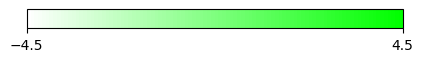

In [7]:
# @title **Visualise 3D protein structure**
# @markdown Enter the **< Protein >** to be viewed.

View = '6WV3_prot_A' # @param {type: 'string'}
Representation_type = 'cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Representation_style = 'white' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Representation_opacity = 1 # @param {type: 'slider', min:0, max:1, step:0.1}
Residue_number = '' # @param {type: 'string'}
Surface_type = 'SES' # @param ['VDW', 'SAS', 'SES', 'MS']
Surface_style = 'hydrophobicity' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Surface_opacity = 1 # @param {type: 'slider', min:0, max:1, step:0.1}
Show_representation = True # @param {type: 'boolean'}
Show_residue = False # @param {type: 'boolean'}
Show_surface = True # @param {type: 'boolean'}

PROT_view_pFile = os.path.join(PRT_FLD, View + '.pdb')

LBSP = LaboSpace(960, 640)
LBSP.load_receptor(PROT_view_pFile)\
    .set_style(
        show_represent=Show_representation,
        represent_type=Representation_type,
        represent_style=builtin_style(
            style=Representation_style,
            opacity=Representation_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))
LBSP.view_space()

show_cscale(
    {Show_representation: Representation_style},
    {Show_surface: Surface_style})

In [8]:
# @title **Parameterise protein with Gasteiger charges**
# @markdown Enter the **< Target Protein >** to be parameterised.\
# @markdown This generate a **`protein.pdbqt`** file after:
# @markdown + Addition of Gasteiger Partial Charge
# @markdown + Addition of polar hydrogens
# @markdown + Removal of non-polar hydrogens

Target_protein = '6WV3_prot_A' # @param {type: 'string'}

PROT_pdb = Target_protein + '.pdb'
PROT_pdbqt = Target_protein + '.pdbqt'
PROT_pdb_pFile = os.path.join(PRT_FLD, PROT_pdb)
PROT_pdb_dFile = os.path.join(DCK_FLD, PROT_pdb)
PROT_pdbqt_dFile = os.path.join(DCK_FLD, PROT_pdbqt)

!obabel {PROT_pdb_pFile} -xr -O {PROT_pdbqt_dFile} -h --partialcharge gasteiger > /dev/null 2>&1
!mk_prepare_receptor.py --pdbqt {PROT_pdbqt_dFile} -o {PROT_pdbqt_dFile} --skip_gpf > /dev/null 2>&1
print(f'+ Parameterisation: {PROT_pdb} > {PROT_pdbqt}')

shutil.copy(PROT_pdb_pFile, PROT_pdb_dFile)
print(f'+ {PROT_pdbqt} > DOCKING folder')
print(f'+ {PROT_pdb} > DOCKING folder')

+ Parameterisation: 6WV3_prot_A.pdb > 6WV3_prot_A.pdbqt
+ 6WV3_prot_A.pdbqt > DOCKING folder
+ 6WV3_prot_A.pdb > DOCKING folder


---
---
# **03 | Preparing the Native Ligand** (optional)

Next, we retrieve the native ligand from the **`pdb`** file to serve as a reference for later comparison. Noted that **this step is optional** as not all **`pdb`** files contain native ligand. However, we highly recommend proceeding with this step for an insightful visual (3D inspection) and qualtitative (RMSD) comparison of binding pose.

In [11]:
# @title **Retrieve native ligand and extract subunits**
# @markdown Enter the **< Keyword >** assigned for query \
# @markdown This generates a **clean** native ligand structure containing multiple
# @markdown binding poses corresponding to each protein subunit(s). \
# @markdown The binding poses are then extracted and corrected into individual
# @markdown **`pdb`** files.

Keyword = 'SWF' # @param {type: 'string'}

def get_molblock(keyword: str) -> str:
    url_path = 'http://files.rcsb.org/ligands/download/' + keyword + '_model.sdf'
    sdf_file = os.path.join(NTV_FLD, keyword + '.sdf')
    os.system(f'wget {url_path} -O {sdf_file} -q')
    molblock = [mol for mol in  Chem.SDMolSupplier(sdf_file) if mol is not None][0]
    os.remove(sdf_file)
    return molblock

def correct_bond_order(inpt_list: list, temp: Chem.rdchem.Mol) -> None:
    for inpt_file in inpt_list:
        targ = AllChem.MolFromPDBFile(inpt_file)
        cmol = AllChem.AssignBondOrdersFromTemplate(temp, targ)
        pdbb = Chem.MolToPDBBlock(cmol, flavor=4)
        with open(inpt_file, 'w') as oupt:
            oupt.write(pdbb)

true_id = Keyword[-3:] if len(Keyword) > 3 else Keyword
print(f'+ RCSB PDB link: https://www.rcsb.org/ligand/{true_id}')

ntv_pdb = Keyword.upper() + '.pdb'
ntv_pdb_nFile = os.path.join(NTV_FLD, ntv_pdb)
extract_entity(PDB_pdb_pFile, ntv_pdb_nFile, [Keyword, 'HETATM'])
extract_chains(ntv_pdb_nFile)

ntv_nFiles = sorted(glob.glob(NTV_FLD + '/' + Keyword + '_*.pdb'))
ntv_smiles = get_molblock(true_id)
correct_bond_order(ntv_nFiles, ntv_smiles)

+ RCSB PDB link: https://www.rcsb.org/ligand/SWF
+ Entity extracted: SWF.pdb > NATIVE folder
+ Chains detected: 1 (A)
+ Chain extracted: SWF_A.pdb > NATIVE folder


In [12]:
# @title **Visualise 3D native ligand**
# @markdown Enter the **< Native Ligand >** to be viewed.

View = 'SWF_A' # @param {type: 'string'}
Representation_type = 'stick' # @param ['line', 'sphere', 'stick']
Show_atom_labels = False # @param {type: 'boolean'}

NTV_view_nFile = os.path.join(NTV_FLD, View + '.pdb')

LBSP = LaboSpace(960, 640)
LBSP.load_ligand(NTV_view_nFile)\
    .set_style(
        show_represent=True,
        represent_type=Representation_type,
        represent_style={'colorscheme': 'lightGreyCarbon'})\
    .label_atoms(
        show_label=Show_atom_labels)
LBSP.view_space()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
# @title **Select native ligand**
# @markdown Enter the **< Target Native Ligand >** for later comparison.

Target_native_ligand = 'SWF_A' # @param {type: 'string'}

NTV_pdb = Target_native_ligand + '.pdb'
NTV_pdb_nFile = os.path.join(NTV_FLD, NTV_pdb)
NTV_pdb_dFile = os.path.join(DCK_FLD, NTV_pdb)

shutil.copy(NTV_pdb_nFile, NTV_pdb_dFile)
print(f'+ {NTV_pdb} > DOCKING folder')

+ SWF_A.pdb > DOCKING folder


---
---
# **04 | Preparing the Ligand**

Now, we start to prepare our ligand of interest. We will be using its SMILES notation to generate a 3D energetically minimised ligand **`sd`** file based on specifed force field and steepest gradient alogrithm. We also parameterise our target ligand to generate the **`pdbqt`** file required for docking.

In [14]:
# @title **Provide ligand information**
# @markdown Enter the **< ID >** and its **< SMILES >** notation.

ID = 'SWF' # @param {type: 'string'}
SMILES = 'CC(=O)CC(C1=CC=CC=C1)C1=C(O)C2=C(OC1=O)C=CC=C2' # @param {type: 'string'}

assert ID.strip(), 'Expected \'ID\'; found \'none\''
assert SMILES.strip(), 'Expected \'SMILES\'; found \'none\''

print(f'+ Ligand \'{ID}\' with \'{SMILES}\' ready for SDF generation')

+ Ligand 'SWF' with 'CC(=O)CC(C1=CC=CC=C1)C1=C(O)C2=C(OC1=O)C=CC=C2' ready for SDF generation


In [15]:
# @title **Generate ligand SD file**
# @markdown Select **< Force Field >** to set MM method for energy minimisation. \
# @markdown Select **< Convergence Criteria >** to set minimum iteration difference required before stopping. **[ Default is 0.00001 ]** \
# @markdown Select **< Maximum Steps >** to set maximum iterations allowed for minimisation. **[ Default is 10000 ]**

Force_field = 'UFF' # @param ['GAFF', 'Ghemical', 'MMFF94', 'MMFF94s', 'UFF']
Convergence_criteria = '0.00001' # @param ['0.1', '0.01','0.001', '0.0001', '0.00001', '0.000001', '0.0000001']
Maximum_steps = 10000 # @param {type: 'slider', min:1000, max:100000, step:1000}

def check_convergence(log_file: str) -> None:
    with open(log_file, 'r') as inpt:
        data = inpt.read()
    if 'CONVERGED' in data:
        verb = 'has'
        step = data.split('\n')[-4].split()[0]
        step_str = f'({step} steps)'
    else:
        verb = 'has not'
        step_str = ''
    print(f'+ Steepest gradient {verb} converged {step_str}')

LIG_ID = ID
LIG_sdf = LIG_ID + '.sdf'
LIG_obmin_log = LIG_ID + '_obmin.log'
LIG_sdf_lFile = os.path.join(LIG_FLD, LIG_sdf)
LIG_obmin_log_lFile = os.path.join(LIG_FLD, LIG_obmin_log)

print(f'+ Selected {Force_field} for energy minimisation '
      f'up to {Convergence_criteria} iteration difference or '
      f'at most {Maximum_steps:,} steps')

!obabel -:{'"'+SMILES+'"'} -O {LIG_sdf_lFile} --title {LIG_ID} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > LIGAND folder')

+ Selected UFF for energy minimisation up to 0.00001 iteration difference or at most 10,000 steps
+ Steepest gradient has converged (3640 steps)
+ SWF.sdf > LIGAND folder


In [18]:
# @title **Visualise 3D ligand**
# @markdown Enter the **< Ligand >** to be viewed.

View = 'SWF' # @param {type: 'string'}
Representation_type = 'stick' # @param ['line', 'sphere', 'stick']
Show_atom_labels = False # @param {type: 'boolean'}

LIG_view_lFile = os.path.join(LIG_FLD, View + '.sdf')

LBSP = LaboSpace(960, 640)
LBSP.load_ligand(LIG_view_lFile)\
    .set_style(
        show_represent=True,
        represent_type=Representation_type,
        represent_style={'colorScheme': 'lightGreyCarbon'})\
    .label_atoms(
        show_label=Show_atom_labels)
LBSP.view_space()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
# @title **Parameterise ligand with Gasteiger charges**
# @markdown This generates a **`ligand.pdbqt`** file after:
# @markdown + Addition of Gasteiger Partial Charge
# @markdown + Removal of non-polar hydrogens

def pdbqt_add_chid(inpt_file: str) -> None:
    with open(inpt_file, 'r') as inpt:
        data = inpt.read()
    new_data = data.replace('  UNL  ', '  UNL A')
    with open(inpt_file, 'w') as oupt:
        oupt.write(new_data)

LIG_pdbqt = ID + '.pdbqt'
LIG_dFLD = os.path.join(DCK_FLD, ID)
LIG_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_pdbqt)
print(LIG_pdbqt)

os.makedirs(LIG_dFLD, exist_ok=True)
!mk_prepare_ligand.py -i {LIG_sdf_lFile} -o {LIG_pdbqt_dFFile} > /dev/null 2>&1
pdbqt_add_chid(LIG_pdbqt_dFFile)

print(f'+ Parameterisation: {LIG_sdf} > {LIG_pdbqt}')
print(f'+ {LIG_pdbqt} > DOCKING folder')

SWF.pdbqt
+ Parameterisation: SWF.sdf > SWF.pdbqt
+ SWF.pdbqt > DOCKING folder


---
---
# **05 | Setting Up Grid Box**

Here, we define a chemical search space with the use of grid box, which often centered within the binding, active or allosteric site of the target protein.

Built-in methods for defining grid box include:

+ **`LaBOX`** : Use the mean of XYZ extreme values from native ligand. [Link](https://github.com/RyanZR/LaBOX)
+ **`eBoxSize`** : Use the radius of gyration of native ligand. [Link](https://github.com/michal-brylinski/eboxsize)
+ **`eBoxSize-Mod`** : Similar to eBoxSize, but box center is computed using LaBOX method.
+ **`Autodock-Grid`** : 22.5 × 22.5 × 22.5 Å
+ **`Defined-by-Res`** : Use when important residues involved in binding interaction are known.
+ **`Manual-Mode`** : Use the sliders below to define grid box.

In [20]:
# @title **Place grid box at binding site**
# @markdown Select **< Method >** to set grid box at the center of binding site.

Residue_number = '' # @param {type: 'string'}
Method = 'LaBOX' # @param ['LaBOX', 'eBoxSize', 'eBoxSize-Mod', 'Autodock-Grid', 'Defined-by-Res', 'Manual-Mode']
Show_residues = True # @param {type: 'boolean'}

# @markdown **Manual Mode**
X = 0 # @param {type: 'number'}
Y = 0 # @param {type: 'number'}
Z = 0 # @param {type: 'number'}
Width = 10 # @param {type: 'number'}
Height = 10 # @param {type: 'number'}
Depth = 10 # @param {type: 'number'}
Scale = 1 # @param {type: 'number'}

LBSP = LaboSpace(960, 640)
LBSP_view = True

try:
    if Method == 'Defined-by-Res':
        GB = GridBox(PROT_pdb_dFile)
        center, bxsize = GB.defined_by_res(Residue_number)
    if Method == 'Manual-Mode':
        center = (X, Y, Z)
        bxsize = (round(Width, 3),
                  round(Height, 3),
                  round(Depth, 3))
except Exception as excp:
    print(f'+ {excp}')
    print(f'+ Error can be:\n'
           '  - Expected \'Residue_number\'; found \'none\'\n'
           '  - Expected \'protein PDB file\'; found \'none\'\n'
           '  - Due to atomic error in \'protein PDB file\'')
    LBSP_view = False
else:
    LBSP.load_receptor(PROT_pdb_dFile)\
        .set_style(
            show_represent=True,
            represent_type='cartoon',
            represent_style={'color': 'white'})\
        .add_residues(
            show_residues=Show_residues,
            residue_number=Residue_number)

try:
    if Method == 'LaBOX':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.labox()
    if Method == 'eBoxSize':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.eboxsize()
    if Method == 'eBoxSize-Mod':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.eboxsize(modified=True)
    if Method == 'Autodock-Grid':
        GB = GridBox(NTV_pdb_nFile)
        center, bxsize = GB.autodock_grid()
except Exception as excp:
    print(f'+ {excp}')
    print(f'+ Expected \'native ligand PDB file\'; found \'none\'')
    print(f'+ Upload file to \'{NTV_FLD}\' and run \'Select native ligand\' cell to load it.')
    LBSP_view = False
else:
    try:
        LBSP.load_ligand(NTV_pdb_nFile)\
            .set_style(
                show_represent=True,
                represent_type='stick',
                represent_style={'colorScheme': 'greyCarbon'})
    except:
        pass

if LBSP_view:
    LBSP.add_gridbox(show_gridbox=True, center=center, bxsize=bxsize)
    LBSP.view_space()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
# @title **Generate docking config file**
# @markdown This generates **`config_file`** for AutoDock Vina.

cfg_name = 'config_file'
cfg_dFile = os.path.join(DCK_FLD, cfg_name)

with open(cfg_dFile, 'w') as cfg:
    cfg.write(f'center_x = {center[0]}\n')
    cfg.write(f'center_y = {center[1]}\n')
    cfg.write(f'center_z = {center[2]}\n')
    cfg.write(f'\n')
    cfg.write(f'size_x = {bxsize[0]}\n')
    cfg.write(f'size_y = {bxsize[1]}\n')
    cfg.write(f'size_z = {bxsize[2]}\n')

print(f'+ {cfg_name} > DOCKING folder')

+ config_file > DOCKING folder


---
---
# **06 | Performing Molecular Docking**

We now proceed with performing molecular docking using Autodock Vina for our target ligand. The duration can vary, mainly influenced by factors including **number of rotatable bonds** and **level of exhaustiveness** selected. Do be patient as the process may take a few minutes to complete.

In [22]:
# @title **Run AutoDock Vina**
# @markdown Select **< Exhaustiveness >** for molecular docking. **[ Default is 16 ]** \
# @markdown This generates a **`ligand_output.pdbqt`** containing different binding poses predicted.

Exhaustiveness = '16' # @param [4, 8, 16, 32, 64, 128, 256]

cpu_cores = os.cpu_count()
LIG_oupt_log = LIG_ID + '_output.log'
LIG_oupt_pdbqt = LIG_ID + '_output.pdbqt'
LIG_oupt_log_dFFile = os.path.join(LIG_dFLD, LIG_oupt_log)
LIG_oupt_pdbqt_dFFile = os.path.join(LIG_dFLD, LIG_oupt_pdbqt)

# -- Start docking --
start = time.time()
%vina --receptor {PROT_pdbqt_dFile} --ligand {LIG_pdbqt_dFFile} \
--out {LIG_oupt_pdbqt_dFFile} --config {cfg_dFile} --cpu {cpu_cores} \
--exhaustiveness {Exhaustiveness} --verbosity 2 | tee {LIG_oupt_log_dFFile}
end = time.time()
# -- End docking --

print(f'')
print(f'+ Docking completed')
print(f'+ Time elapsed: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))
print(f'+ {LIG_oupt_pdbqt} > DOCKING folder')

AutoDock Vina v1.2.5
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, J. Comp. Chem. (2010)                         #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see https://github.com/ccsb-scripps/AutoDock-V

In [23]:
# @title **Process output file**
# @markdown This generates **`ligand_[n].pdb`** for each predicted binding poses.

LIG_dash_pdb = LIG_ID + '_.pdb'
LIG_dash_pdb_dFFile = os.path.join(LIG_dFLD, LIG_dash_pdb)

with open(LIG_oupt_pdbqt_dFFile, 'r') as oupt:
    data = oupt.read()
    pose = data.count('MODEL')

!obabel {LIG_oupt_pdbqt_dFFile} -O {LIG_dash_pdb_dFFile} -m > /dev/null 2>&1
print(f'+ {pose} {LIG_ID}_[n].pdb > DOCKING folder')

+ 9 SWF_[n].pdb > DOCKING folder


---
---
# **07 | Profiling Binding Interactions**

After docking, we use PLIP to determine the non-covalent binding interactions between the docked ligand and target protein. We will prepare the required complex **`pdb`** file containing docked ligand pose and target protein for PLIP to profile interactions.

In [24]:
# @title **Generate complex PDB file**
# @markdown This merges the target protein with each docked ligand poses to
# @markdown produce individual **`cmpx.pdb`** file.

def generate_cmpx_pdb(inpt_prot: str, inpt_pose: str, oupt_cmpx: str) -> None:

    def write_line(line: str, keywords: list, oupt_file: str) -> None:
        header = line.split()[0]
        if header in keywords:
            oupt_file.write(line)

    def cmpx_writer() -> None:
        with open(oupt_cmpx, 'w') as oupt_file, \
             open(inpt_prot, 'r') as prot_file, \
             open(inpt_pose, 'r') as pose_file:
            for prot_line in prot_file:
                write_line(prot_line, prot_headers, oupt_file)
            for pose_line in pose_file:
                write_line(pose_line, pose_headers, oupt_file)

    prot_headers = ['ATOM', 'CONECT', 'TER']
    pose_headers = ['ATOM', 'CONECT', 'END']
    cmpx_writer()

LIG_iFLD = os.path.join(INT_FLD, LIG_ID)
os.makedirs(LIG_iFLD, exist_ok=True)
LIG_pdb_dFFiles = sorted(glob.glob(LIG_dFLD + '/*.pdb'))

count = 0
for pose_file in tqdm(LIG_pdb_dFFiles):
    pose_name = os.path.basename(pose_file).split('.')[0]
    cmpx_pdb = pose_name + '_cmpx.pdb'
    cmpx_pdb_iFile = os.path.join(LIG_iFLD, cmpx_pdb)
    generate_cmpx_pdb(PROT_pdb_dFile, pose_file, cmpx_pdb_iFile)
    count += 1

print(f'+ {count} {LIG_ID}_[n]_cmpx.pdb > INTERACTION folder')

  0%|          | 0/9 [00:00<?, ?it/s]

+ 9 SWF_[n]_cmpx.pdb > INTERACTION folder


In [25]:
# @title **Run PLIP**
# @markdown This generates an **`interpt.csv`** containing all detected binding
# @markdown interaction for each individual **`cmpx.pdb`** file. \
# @markdown Supported: **`HYDROPHOBIC`**, **`HBOND`**, **`WATERBRIDGE`**,
# @markdown **`SALTBRIDGE`**, **`PISTACKING`**, **`PICATION`**, **`HALOGEN`**, **`METAL`**. \

def interaction_profiler(inpt_cmpx: str, oupt_csv: str) -> None:

    int_bonds = ['HYDROPHOBIC', 'HBOND', 'WATERBRIDGE', 'SALTBRIDGE',
                 'PISTACKING', 'PICATION', 'HALOGEN', 'METAL']

    def BSR(inpt_cmpx: str) -> object:
        cmpx_mol = PDBComplex()
        cmpx_mol.load_pdb(inpt_cmpx)
        cmpx_lig = [lig for lig in cmpx_mol.ligands if lig.hetid == 'UNL'][0]
        cmpx_mol.characterize_complex(cmpx_lig)
        cmpx_int = cmpx_mol.interaction_sets['UNL:A:1']
        cmpx_rpt = BindingSiteReport(cmpx_int)
        return cmpx_rpt

    def BSR_feat(bsr: object) -> list:
        return [list(getattr(bsr, bond.lower() + '_features')) + ['BOND']
                for bond in int_bonds]

    def BSR_info(bsr: object) -> list:
        return [[list(info) + [bond] for info in getattr(bsr, bond.lower() + '_info')]
                for bond in int_bonds]

    def replace_column(df: pd.DataFrame, col_A: str, cols: list) -> pd.DataFrame:
        for col in cols:
            if col in df.columns:
                df[col_A] = df[col_A].fillna(df[col])
            else:
                pass
        return df

    def BSR_dataframe(bsr_feat: list, bsr_info: list) -> pd.DataFrame:
        bsr_df = []
        for feat, info in zip(bsr_feat, bsr_info):
            if info:
                df = pd.DataFrame(info, columns=feat)
            else:
                df = pd.DataFrame(columns=bsr_feat[0])
            bsr_df.append(df)
        BSR_df = pd.concat(bsr_df, ignore_index=True)
        BSR_df = replace_column(BSR_df, 'DIST', ['DIST_D-A', 'CENTDIST'])
        return BSR_df

    cmpx_bsr = BSR(inpt_cmpx)
    bsr_feat = BSR_feat(cmpx_bsr)
    bsr_info = BSR_info(cmpx_bsr)
    bsr_data = BSR_dataframe(bsr_feat, bsr_info)
    bsr_data.to_csv(oupt_csv, index=False)

cmpx_pdb_iFFiles = sorted(glob.glob(LIG_iFLD + '/*_cmpx.pdb'))

count = 0
for cmpx_file in tqdm(cmpx_pdb_iFFiles):
    cmpx_name = os.path.basename(cmpx_file).split('.')[0][:-5]
    inter_csv = cmpx_name + '_interpt.csv'
    inter_csv_iFile = os.path.join(LIG_iFLD, inter_csv)
    interaction_profiler(cmpx_file, inter_csv_iFile)
    count += 1

print(f'+ {count} {LIG_ID}_[n]_interpt.csv > INTERACTION folder')

  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-25-6877f0361def>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  BSR_df = pd.concat(bsr_df, ignore_index=True)
<ipython-input-25-6877f0361def>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  BSR_df = pd.concat(bsr_df, ignore_index=True)
<ipython-input-25-6877f0361def>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. 

+ 9 SWF_[n]_interpt.csv > INTERACTION folder


<ipython-input-25-6877f0361def>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  BSR_df = pd.concat(bsr_df, ignore_index=True)


---
---
# **08 | Analysing Docking Results**

We process all the docking and binding internaction results generated into for further evaluation. We will compute the RMSD between native ligand and docked ligands using three different calculation methods. We will also visualise the docking pose in three-dimensional chemical space.

In [26]:
# @title **Generate docking report**
# @markdown This clusters the docking score from the docked ligand pose **`pdb`**
# @markdown file and computes the RMSD with different 3 methods. \
# @markdown The report is then saved into a **`ligand_dockrpt.csv`** file.

def vina_report(inpt_file: str) -> dict:

    def vn_scores(inpt_file: str) -> float:
        with open(inpt_file, 'r') as inpt_data:
            for line in inpt_data:
                if 'REMARK VINA RESULT' in line:
                    dock_sc = float(line.split()[3])
                    rmsd_lb = float(line.split()[4])
                    rmsd_ub = float(line.split()[5])
        return dock_sc, rmsd_lb, rmsd_ub

    def vn_report(name: str, scores: tuple) -> dict:
        return {'NAME': [name], 'DOCK_SC': [scores[0]],
                'RMSD_LB': [scores[1]], 'RMSD_UB': [scores[2]]}

    inpt_name = os.path.basename(inpt_file).split('.')[0]
    scores = vn_scores(inpt_file)
    report = vn_report(inpt_name, scores)
    return report

LIG_MCS_png = LIG_ID + '_MCS.png'
LIG_dockrpt_csv = LIG_ID + '_dockrpt.csv'
LIG_MCS_png_dFFile = os.path.join(LIG_dFLD, LIG_MCS_png)
LIG_dockrpt_csv_dFFile = os.path.join(LIG_dFLD, LIG_dockrpt_csv)

RMSD = ComputeRMSD()
dock_rpt = pd.DataFrame()

try:
    ref_info = RMSD.load_molecule(NTV_pdb_dFile)
except:
    print('+ Expected \'native ligand PDB file\' for RMSD calculation; found \'none\'.')
    print('+ Docking report generation proceeded without RMSD calculation.')
    for lig_file in LIG_pdb_dFFiles:
        vina_rpt = pd.DataFrame.from_dict(vina_report(lig_file))
        dock_rpt = pd.concat([dock_rpt, vina_rpt], ignore_index=True)
else:
    for lig_file in LIG_pdb_dFFiles:
        lig_info = RMSD.load_molecule(lig_file)
        vina_rpt = pd.DataFrame.from_dict(vina_report(lig_file))
        rmsd_rpt = pd.DataFrame.from_dict(RMSD.rmsd_report(ref_info, lig_info)).drop(['NAME'], axis=1)
        pose_rpt = pd.concat([vina_rpt, rmsd_rpt], axis=1)
        dock_rpt = pd.concat([dock_rpt, pose_rpt], ignore_index=True)
    RMSD.MCS_png.save(LIG_MCS_png_dFFile)

dock_rpt.to_csv(LIG_dockrpt_csv_dFFile, index=False)
print(f'+ {LIG_ID}_dockrpt.csv > DOCKING folder')

+ SWF_dockrpt.csv > DOCKING folder


In [27]:
# @title **Show docking report**
# @markdown Enter the **< Ligand Name >** to view docking score and RMSD.
# @markdown + **`DOCK_SC`** : Autodock Vina Docking Score
# @markdown + **`RMSD_LB`** : RMSD Lower Bound (vs Best Pose)
# @markdown + **`RMSD_UB`** : RMSD Upper Bound (vs Best Pose)
# @markdown + **`LABO_RMSD`** : RMSD by Common Substructure (vs Native Ligand)
# @markdown + **`HUNG_RMSD`** : RMSD by Hungarian Algorithm (vs Native Ligand)
# @markdown + **`SYMM_RMSD`** : Symmetrical-corrected RMSD (vs Native Ligand)

Ligand_name = 'SWF' # @param {type : 'string'}

LIG_dockrpt_csv = Ligand_name + '_dockrpt.csv'
LIG_dockrpt_csv_dFile = os.path.join(LIG_dFLD, LIG_dockrpt_csv)
LIG_dockrpt_df = pd.read_csv(LIG_dockrpt_csv_dFile)
LIG_dockrpt_df

,NAME,DOCK_SC,RMSD_LB,RMSD_UB,LABO_RMSD,HUNG_RMSD,SYMM_RMSD
0,SWF_1,-11.078,0.000,0.000,1.419,1.060,1.089
1,SWF_2,-10.567,1.059,2.239,2.536,1.610,2.375
2,SWF_3,-10.316,1.704,2.692,3.218,3.218,3.218
3,SWF_4,-10.170,2.074,3.575,4.020,3.601,4.020
4,SWF_5,-9.789,1.759,5.708,5.850,3.116,5.764
5,SWF_6,-9.563,1.275,3.334,3.503,1.966,3.393
6,SWF_7,-9.476,1.412,4.080,4.185,2.359,4.170
7,SWF_8,-9.299,2.395,6.501,6.533,3.743,6.533
8,SWF_9,-9.189,1.995,6.252,6.381,3.545,6.304


In [28]:
# @title **Show interaction profile**
# @markdown Enter the **< Pose Name >** to view the binding interactions.

Pose_name = 'SWF_1' # @param {type : 'string'}

LIG_interpt_csv = Pose_name + '_interpt.csv'
LIG_interpt_csv_iFile = os.path.join(LIG_iFLD, LIG_interpt_csv)
LIG_interpt_dict = interaction_dict(LIG_interpt_csv_iFile, usage='view')
LIG_interpt_df = pd.DataFrame.from_dict(LIG_interpt_dict)
LIG_interpt_df = LIG_interpt_df[['RESTYPE', 'RESNR', 'DIST', 'BOND', 'COLOR']]
LIG_interpt_df

,RESTYPE,RESNR,DIST,BOND,COLOR
0,PHE,197,3.75,HYDROPHOBIC,GREEN
1,PHE,205,3.96,HYDROPHOBIC,GREEN
2,LEU,262,3.56,HYDROPHOBIC,GREEN
3,VAL,276,3.91,HYDROPHOBIC,GREEN
4,THR,280,3.91,HYDROPHOBIC,GREEN
5,VAL,196,3.74,HYDROPHOBIC,GREEN
6,TRP,201,3.60,HYDROPHOBIC,GREEN
7,ASN,222,3.67,HYDROPHOBIC,GREEN
8,THR,280,3.07,HBOND,LIGHT BLUE
9,ASN,222,3.17,HBOND,LIGHT BLUE


In [29]:
# @title **Visualise 3D docking pose**
# @markdown **PROTEIN MODEL** \
# @markdown Enter the **< Protein >** to be viewed.

View_protein = '6WV3_prot_A' # @param {type: 'string'}
Protein_type = 'cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Protein_style = 'white' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Protein_opacity = 0.5 # @param {type: 'slider', min:0, max:1, step:0.1}
Residue_number = '' # @param {type: 'string'}
Surface_type = 'SES' # @param ['VDW', 'SAS', 'SES', 'MS']
Surface_style = 'isoelectric points' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Surface_opacity = 0.5 # @param {type: 'slider', min:0, max:1, step:0.1}
Show_protein = True # @param {type: 'boolean'}
Show_residue = False # @param {type: 'boolean'}
Show_surface = False # @param {type: 'boolean'}
Show_gridbox = False # @param {type: 'boolean'}

# @markdown **LIGAND MODEL** \
# @markdown Enter the **< Ligand >** to be viewed.

View_native_ligand = 'SWF_A' # @param {type: 'string'}
Native_ligand_style = 'stick' # @param ['cross', 'line', 'sphere', 'stick']
Show_native_ligand = True # @param {type: 'boolean'}
View_docked_ligand = 'SWF_1' # @param {type: 'string'}
Docked_ligand_style = 'stick' # @param ['cross', 'line', 'sphere', 'stick']
Show_docked_ligand = True # @param {type: 'boolean'}

# @markdown **INTERACTION MODEL** \
# @markdown Enter the **< Interaction Type >** to be viewed. \
# @markdown Select or combine from **`HYDROPHOBIC`**, **`HBOND`**, **`WATERBRIDGE`**,
# @markdown **`SALTBRIDGE`**, **`PISTACKING`**, **`PICATION`**, **`HALOGEN`**, **`METAL`**. \
# @markdown *Note: All interactions are selected if not provided.*

Interaction_type = "HBOND, WATERBRIDGE, SALTBRIDGE, PISTACKING, PICATION, HALOGEN, METAL" # @param {type: 'string'}
Show_interaction = True # @param {type: 'boolean'}

# @markdown **OTHER OPTIONS** \
# @markdown Miscellaneous visualisation settings.

Slab_view = False # @param {type: 'boolean'}

dLIG_dFLD = os.path.join(DCK_FLD, View_docked_ligand[:-2])
iLIG_iFLD = os.path.join(INT_FLD, View_docked_ligand[:-2])
PROT_view_dFile = os.path.join(DCK_FLD, View_protein + '.pdb')
NTV_view_dFile = os.path.join(DCK_FLD, View_native_ligand + '.pdb')
LIG_view_dFFile = os.path.join(dLIG_dFLD, View_docked_ligand + '.pdb')
INT_view_iFFile = os.path.join(iLIG_iFLD, View_docked_ligand + '_interpt.csv')
cfg_center, cfg_bxsize = extract_config(cfg_dFile)

LBSP = LaboSpace(960, 640)
LBSP.load_receptor(PROT_view_dFile)\
    .set_style(
        show_represent=Show_protein,
        represent_type=Protein_type,
        represent_style=builtin_style(
            style=Protein_style,
            opacity=Protein_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))

try:
    LBSP.load_ligand(NTV_view_dFile)\
        .set_style(
            show_represent=Show_native_ligand,
            represent_type=Native_ligand_style,
            represent_style={'color': 'grey'})
except:
    pass

LBSP.load_ligand(LIG_view_dFFile)\
    .set_style(
        show_represent=Show_docked_ligand,
        represent_type=Docked_ligand_style,
        represent_style={'colorscheme': 'salmonCarbon'})
LBSP.add_interaction(
    interaction_file=INT_view_iFFile,
    show_interaction=Show_interaction,
    select_interaction=Interaction_type)
LBSP.add_gridbox(
    show_gridbox=Show_gridbox,
    center=cfg_center,
    bxsize=cfg_bxsize)
LBSP.view_space(
    slab_view=Slab_view)

show_cscale({Show_protein: Protein_style}, {Show_surface: Surface_style})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
---
# **09 | Save to Google Drive**

Finally, we save all the generated data into Google Drive. A copy of the current working directory will be stored in our specified destination in Google Drive.

In [30]:
# @title **Mount Google Drive**
# @markdown This flush and mount Google Drive.

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [31]:
# @title **Store data**
# @markdown Enter the **< Destination >** for storage. \
# @markdown This copies all generated data from current working directory into
# @markdown specified destination.

Destination = '/content/drive/MyDrive/Docking' # @param {type: 'string'}

DST_FLD = os.path.join(Destination, Job_name)
shutil.copytree(WRK_DIR, DST_FLD)

print(f'+ {Job_name} stored in {DST_FLD}')

+ 6WV3 stored in /content/drive/MyDrive/Docking/6WV3
